Time taken : 0.188778 sec


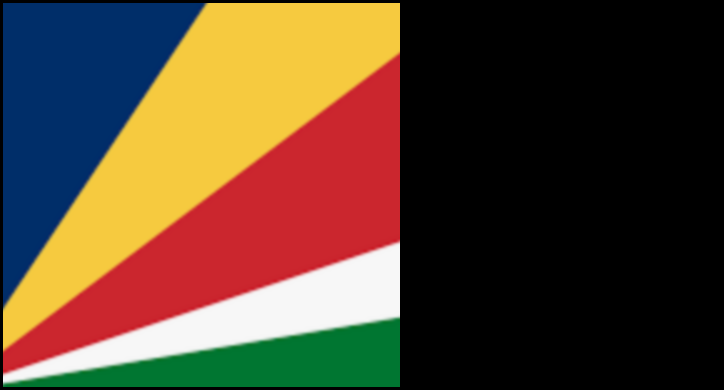

In [29]:
#### GPU Gauss blur without shared memory ####

from PIL import Image
import time
import numpy as np
from numba import cuda, config
import matplotlib.pyplot as plt
config.CUDA_ENABLE_PYNVJITLINK = 1

# Kernel from presentation
kernel = np.array([
    [0, 0, 1, 2, 1, 0, 0],
    [0, 3, 13, 22, 13, 3, 0],
    [1, 13, 59, 97, 59, 13, 1],
    [2, 22, 97,159, 97, 22, 2],
    [1, 13, 59, 97, 59, 13, 1],
    [0, 3, 13, 22, 13, 3, 0],
    [0, 0, 1, 2, 1, 0, 0]
], dtype=np.float32)
kernel /= kernel.sum()

# Function to convert in a blur image
@cuda.jit   # For GPU
def gauss_blur_gpu(src, dst, kernel, kernel_size):
    x, y = cuda.grid(2)
    half = kernel_size // 2
    if x >= half and y >= half and x < src.shape[0] - half and y < src.shape[1] - half:
        r_sum = 0.0
        g_sum = 0.0
        b_sum = 0.0
        norm_factor = 0.0

        # Convolution
        for i in range(-half, half + 1):
            for j in range(-half, half + 1):
                weight = kernel[half + i][half + j]
                r = src[x + i, y + j, 0]
                g = src[x + i, y + j, 1]
                b = src[x + i, y + j, 2]
                r_sum += r * weight
                g_sum += g * weight
                b_sum += b * weight
                norm_factor += weight

        dst[x, y, 0] = r_sum / norm_factor # Average
        dst[x, y, 1] = g_sum / norm_factor
        dst[x, y, 2] = b_sum / norm_factor


img = Image.open('/content/image.PNG').convert("RGB")  # Load image
rgb_array = np.array(img, dtype=np.float32)
height, width, _ = rgb_array.shape
dst = np.zeros_like(rgb_array, dtype=np.float32) # Allow memory

d_src = cuda.to_device(rgb_array) # Input
d_dst = cuda.to_device(dst) # Output
d_kernel = cuda.to_device(kernel)

threads_per_block = (16, 16)  # 16x16 block size 2D
blocks_x = (width + threads_per_block[0] - 1) // threads_per_block[1]
blocks_y = (height + threads_per_block[0] - 1) // threads_per_block[1]

start_time = time.time() # Timer
gauss_blur_gpu[(blocks_x, blocks_y), threads_per_block](d_src, d_dst, d_kernel, 7)
cuda.synchronize()
end_time = time.time() # Timer

print(f"Time taken : {end_time - start_time:.6f} sec")

# Display and result
result = d_dst.copy_to_host()
result_c = np.clip(result, 0, 255).astype(np.uint8) # Converting
img_result = Image.fromarray(result_c)
display(img_result)

Block size = 4 x 4  ->  Time taken : 0.195970 sec
Block size = 8 x 8  ->  Time taken : 0.001833 sec
Block size = 12 x 12  ->  Time taken : 0.002186 sec
Block size = 16 x 16  ->  Time taken : 0.001796 sec
Block size = 20 x 20  ->  Time taken : 0.001833 sec
Block size = 24 x 24  ->  Time taken : 0.001982 sec
Block size = 28 x 28  ->  Time taken : 0.001786 sec
Block size = 32 x 32  ->  Time taken : 0.002189 sec


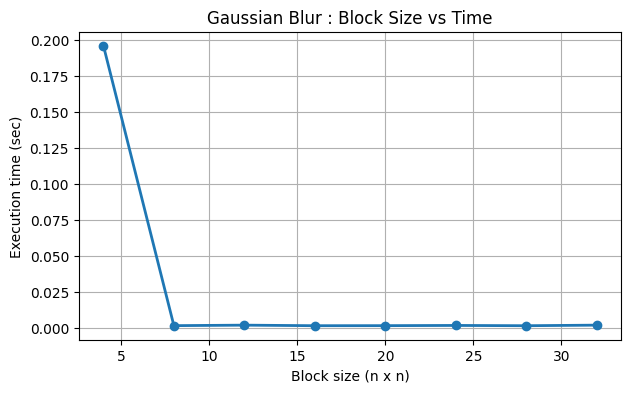

In [53]:
#### GPU Gauss blur without shared memory ####

from PIL import Image
import time
import numpy as np
from numba import cuda, config
import matplotlib.pyplot as plt
config.CUDA_ENABLE_PYNVJITLINK = 1

# Kernel from presentation
kernel = np.array([
    [0, 0, 1, 2, 1, 0, 0],
    [0, 3, 13, 22, 13, 3, 0],
    [1, 13, 59, 97, 59, 13, 1],
    [2, 22, 97,159, 97, 22, 2],
    [1, 13, 59, 97, 59, 13, 1],
    [0, 3, 13, 22, 13, 3, 0],
    [0, 0, 1, 2, 1, 0, 0]
], dtype=np.float32)
kernel /= kernel.sum()

# Function to convert in a blur image
@cuda.jit   # For GPU
def gauss_blur_gpu(src, dst, kernel, kernel_size):
    x, y = cuda.grid(2)
    half = kernel_size // 2
    if x >= half and y >= half and x < src.shape[0] - half and y < src.shape[1] - half:
        r_sum = 0.0
        g_sum = 0.0
        b_sum = 0.0
        norm_factor = 0.0

        # Convolution
        for i in range(-half, half + 1):
            for j in range(-half, half + 1):
                weight = kernel[half + i][half + j]
                r = src[x + i, y + j, 0]
                g = src[x + i, y + j, 1]
                b = src[x + i, y + j, 2]
                r_sum += r * weight
                g_sum += g * weight
                b_sum += b * weight
                norm_factor += weight

        dst[x, y, 0] = r_sum / norm_factor # Average
        dst[x, y, 1] = g_sum / norm_factor
        dst[x, y, 2] = b_sum / norm_factor


img = Image.open('/content/image.PNG').convert("RGB")  # Load image
rgb_array = np.array(img, dtype=np.float32)
height, width, _ = rgb_array.shape
dst = np.zeros_like(rgb_array, dtype=np.float32) # Allow memory

d_src = cuda.to_device(rgb_array) # Input
d_dst = cuda.to_device(dst) # Output
d_kernel = cuda.to_device(kernel)

block_sizes = [4, 8, 12, 16, 20, 24, 28, 32]
times = []

for threads_per_block in block_sizes:
    blocks_x = (width + threads_per_block - 1) // threads_per_block
    blocks_y = (height + threads_per_block - 1) // threads_per_block

    start_time = time.time() # Timer
    gauss_blur_gpu[(blocks_x, blocks_y), (threads_per_block,threads_per_block)](d_src, d_dst, d_kernel, 7)
    cuda.synchronize()
    end_time = time.time() # Timer

    time_ = end_time - start_time # Timer
    times.append(time_)
    print(f"Block size = {threads_per_block} x {threads_per_block}  ->  Time taken : {time_:.6f} sec")

# Graph
plt.figure(figsize=(7,4))
plt.plot(block_sizes, times, marker='o', linewidth=2)
plt.xlabel('Block size (n x n)')
plt.ylabel('Execution time (sec)')
plt.title('Gaussian Blur : Block Size vs Time')
plt.grid(True)
plt.show()


Block size = 4 x 4  ->  Time taken : 0.285604 sec
Block size = 8 x 8  ->  Time taken : 0.002195 sec
Block size = 12 x 12  ->  Time taken : 0.002119 sec
Block size = 16 x 16  ->  Time taken : 0.001880 sec
Block size = 20 x 20  ->  Time taken : 0.001903 sec
Block size = 24 x 24  ->  Time taken : 0.002050 sec


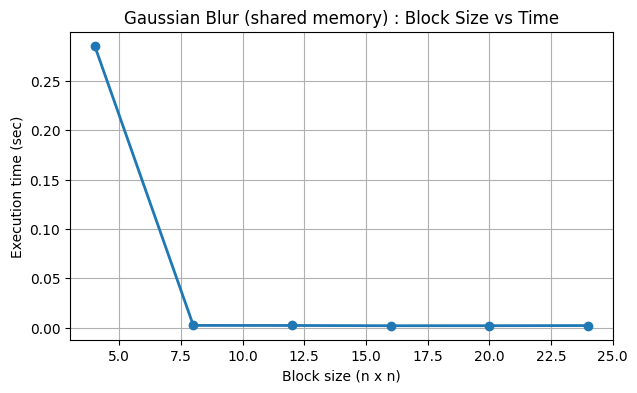

In [57]:
#### GPU Gauss blur with shared memory ####

from PIL import Image
import time
import numpy as np
from numba import cuda, config
import matplotlib.pyplot as plt
config.CUDA_ENABLE_PYNVJITLINK = 1

# Kernel from presentation
kernel = np.array([
    [0, 0, 1, 2, 1, 0, 0],
    [0, 3, 13, 22, 13, 3, 0],
    [1, 13, 59, 97, 59, 13, 1],
    [2, 22, 97,159, 97, 22, 2],
    [1, 13, 59, 97, 59, 13, 1],
    [0, 3, 13, 22, 13, 3, 0],
    [0, 0, 1, 2, 1, 0, 0]
], dtype=np.float32)
kernel /= kernel.sum()
kernel_size = kernel.shape[0]

# Function to convert in a blur image
@cuda.jit   # For GPU
def gauss_blur_gpu_2(src, dst, kernel, kernel_size):
    x, y = cuda.grid(2)
    half = kernel_size // 2
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    shared_width = cuda.blockDim.x + 2 * half
    shared_height = cuda.blockDim.y + 2 * half
    shared_mem = cuda.shared.array(shape=(64, 64, 3), dtype=float32) # Shared memory
    for c in range(3):
        global_x = x - half
        global_y = y - half

        if (0 <= global_x < src.shape[0]) and (0 <= global_y < src.shape[1]):
            shared_mem[tx + half, ty + half, c] = src[global_x, global_y, c]
        else:
            shared_mem[tx + half, ty + half, c] = 0.0
    cuda.syncthreads() # Synchronize threads

    # Convolution
    if half <= x < src.shape[0] - half and half <= y < src.shape[1] - half:
        r_sum = 0.0
        g_sum = 0.0
        b_sum = 0.0
        norm_factor = 0.0
        for i in range(-half, half + 1):
            for j in range(-half, half + 1):
                weight = kernel[half + i, half + j]
                r_sum += shared_mem[tx + i + half, ty + j + half, 0] * weight
                g_sum += shared_mem[tx + i + half, ty + j + half, 1] * weight
                b_sum += shared_mem[tx + i + half, ty + j + half, 2] * weight
                norm_factor += weight

        dst[x, y, 0] = r_sum / norm_factor # Average
        dst[x, y, 1] = g_sum / norm_factor
        dst[x, y, 2] = b_sum / norm_factor

img = Image.open('/content/image.PNG').convert("RGB")  # Load image
rgb_array = np.array(img, dtype=np.float32)
height, width, _ = rgb_array.shape
dst = np.zeros_like(rgb_array, dtype=np.float32) # Allow memory

# Copier les données vers le GPU
d_src = cuda.to_device(rgb_array)
d_dst = cuda.to_device(dst)
d_kernel = cuda.to_device(kernel)

block_sizes = [4, 8, 12, 16, 20, 24]
times = []

for threads_per_block in block_sizes:
    blocks_x = (width + threads_per_block - 1) // threads_per_block
    blocks_y = (height + threads_per_block - 1) // threads_per_block

    start_time = time.time()
    gauss_blur_gpu_2[(blocks_x, blocks_y), (threads_per_block, threads_per_block)](d_src, d_dst, d_kernel, kernel_size)
    cuda.synchronize()
    end_time = time.time()

    duration = end_time - start_time
    times.append(duration)
    print(f"Block size = {threads_per_block} x {threads_per_block}  ->  Time taken : {duration:.6f} sec")

# Graph
plt.figure(figsize=(7,4))
plt.plot(block_sizes, times, marker='o', linewidth=2)
plt.xlabel('Block size (n x n)')
plt.ylabel('Execution time (sec)')
plt.title('Gaussian Blur (shared memory) : Block Size vs Time')
plt.grid(True)
plt.show()
